<a href="https://colab.research.google.com/github/SMarco2310/AI-Project/blob/branch2/Intro_to_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Processing**


 We try to rescale all the picture to 160x160 to make the use of the face net algorithm easy

 # **Steps:**

## **Steps 1: Create and new folder to save the changes we made**

- Create new directory for the transformed data
- read the data

- create a function that resize the pictures

## **Step2: Ensure uniform color format and resize all the picture to 160x160**
- resize all the pictures to the 160*160 format
- create a function that changes the color of the picture to RGB color format

## Step3: Change the image format to PNG
- Create a function to convert all the picture from whatever format to PNG


In [ ]:
### Libraries to be used for this task
! pip install opencv-python
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
# This is to have before and after view of the picture

# Before

display_picture = cv2.imread("/content/sample_data/image1.png")
img= cv2.cvtColor(display_picture, cv2.COLOR_BGR2RGB)
plt.imshow(img)

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# Resizing function

In [ ]:
def resize_image(picture_name:str):
   img = cv2.imread(picture_name)
   # This resizes the picture to the 160x160 format
   img = cv2.resize(img, (160,160))
   cv2.imwrite("resized_"+picture_name, img)
   # This ensures the RGB color format
   img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
   return img

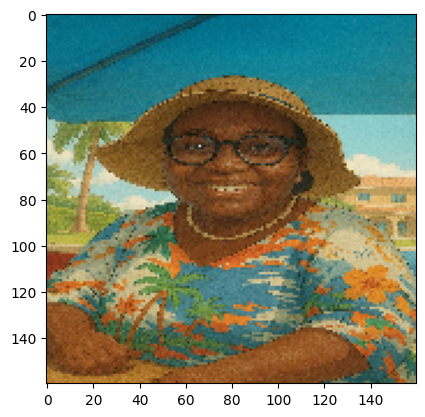

In [ ]:
# After

img1 = resize_image("/content/sample_data/image1.png")
plt.imshow(img1)

Here is a code I found to create new directory:

The code should be edited so that when looping throught the directory,the changes will be applied to the files and they will be moved to new directory

In [ ]:
from google import colab
colab.drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import os
import cv2

def resize_image(picture_path: str, output_path: str):
    img = cv2.imread(picture_path)
    if img is not None:  # Check if image was loaded successfully
        img = cv2.resize(img, (160, 160))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        cv2.imwrite(output_path, img)
    else:
        print(f"Could not read image: {picture_path}")  # Print an error message
    return img


def loop_through_folders(input_dir, output_dir, file_limit=32):
    """
    Loops through the folders in the given directory, processes images,
    and outputs them to a new directory maintaining the structure.

    Args:
        input_dir: The input directory containing the images.
        output_dir: The output directory to save the processed images.
        file_limit: The maximum number of files to process in each subfolder.
    """
    for root, dirs, files in os.walk(input_dir):
        # Compute relative path from input_dir to current root
        rel_path = os.path.relpath(root, input_dir)
        # Create equivalent directory inside output_dir
        target_dir = os.path.join(output_dir, rel_path)
        os.makedirs(target_dir, exist_ok=True)

        file_count = 0  # Initialize file count for each subfolder
        for file in files:
            if file.lower().endswith((".png", ".jpg", ".jpeg")):
                if file_count < file_limit:  # Check if file limit is reached
                    #file = str(file)[0] + ".png" # This line was causing the problem
                    input_path = os.path.join(root, file)
                    # Assuming you want to keep the original filename and just change the extension to .png:
                    name, ext = os.path.splitext(file)
                    output_path = os.path.join(target_dir, name + ".png")
                    resize_image(input_path, output_path)
                    file_count += 1  # Increment file count
                else:
                    break  # Stop processing files in this subfolder

# Example usage:
input_directory = "/content/drive/MyDrive/val"
output_directory = "/content/drive/MyDrive/result"
os.makedirs(output_directory, exist_ok=True)

loop_through_folders(input_directory, output_directory, file_limit=32)  # Set file limit to 32

KeyboardInterrupt: 

**PRE TRAINED FACENET ALGORITHM** (INCEPTION RESNET)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a basic Convolutional Layer for reuse in blocks
class FacenetLayer(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0):
        super(FacenetLayer, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_planes, eps=0.001, momentum=0.1, affine=True)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x


class Block35(nn.Module):
    def __init__(self, scale=1.0):
        super(Block35, self).__init__()
        self.scale = scale
        self.branch0 = FacenetLayer(256, 32, kernel_size=1)
        self.branch1 = nn.Sequential(
            FacenetLayer(256, 32, kernel_size=1),
            FacenetLayer(32, 32, kernel_size=3, padding=1)
        )
        self.branch2 = nn.Sequential(
            FacenetLayer(256, 64, kernel_size=1),
            FacenetLayer(64, 64, kernel_size=3, padding=1),
            FacenetLayer(64, 64, kernel_size=3, padding=1)
        )
        self.conv2d = nn.Conv2d(128, 256, kernel_size=1, stride=1)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        out = torch.cat((y0, y1, y2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


# class Block17(nn.Module):
#     def __init__(self, scale=1.0):
#         super(Block17, self).__init__()
#         self.scale = scale
#         self.branch0 = FacenetLayer(896, 128, kernel_size=1)
#         # The input channels of the first layer in branch1 was changed from 256 to 896
#         # to match the actual number of channels in the input tensor 'x'
#         self.branch1 = nn.Sequential(
#             FacenetLayer(896, 32, kernel_size=1), # Changed here
#             FacenetLayer(32, 32, kernel_size=(1, 1), padding=(0, 3)),
#             FacenetLayer(32, 128, kernel_size=(7, 1), padding=(3, 0)) # Changed here
#         )
#         # The input channels of the first and second layer in branch2 was changed from 256 and 64 to 896 and 128 respectively
#         # to match the actual number of channels in the input tensor 'x' and output from previous layer
#         self.branch2 = nn.Sequential(
#             FacenetLayer(896, 96, kernel_size=1), # Changed here
#             FacenetLayer(96, 64, kernel_size=3, padding=1), # Changed here
#             FacenetLayer(64, 64, kernel_size=3, padding=1)
#         )
#         self.conv2d = nn.Conv2d(256, 896, kernel_size=1, stride=1)
#         self.relu = nn.ReLU(inplace=False)

#     def forward(self, x):
#         y0 = self.branch0(x)
#         y1 = self.branch1(x)
#         y2 = self.branch2(x)
#         out = torch.cat((y0, y1, y2), 1)
#         out = self.conv2d(out)
#         out = out * self.scale + x
#         out = self.relu(out)
#         return out

class Block17(nn.Module):
    def __init__(self, scale=1.0):
        super(Block17, self).__init__()
        self.scale = scale
        self.branch0 = FacenetLayer(896, 128, kernel_size=1)
        # The input channels of the first layer in branch1 was changed from 256 to 896
        # to match the actual number of channels in the input tensor 'x'
        self.branch1 = nn.Sequential(
            FacenetLayer(896, 128, kernel_size=1), # Changed here
            FacenetLayer(128, 128, kernel_size=(1,7), padding=(0,3)),  # Changed here
            FacenetLayer(128, 128, kernel_size=(7,1), padding=(3,0))  # Changed here
        )
        # The input channels of the first and second layer in branch2 was changed from 256 and 64 to 896 and 128 respectively
        # to match the actual number of channels in the input tensor 'x' and output from previous layer
        self.branch2 = nn.Sequential(
            FacenetLayer(896, 128, kernel_size=1), # Changed here
            FacenetLayer(128, 128, kernel_size=3, padding=1),#changed here
            FacenetLayer(128, 128, kernel_size=3, padding=1) #changed here
        )
        self.conv2d = nn.Conv2d(384, 896, kernel_size=1, stride=1) #changed here
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        y2 = self.branch2(x)
        out = torch.cat((y0, y1, y2), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        out = self.relu(out)
        return out


class Block8(nn.Module):
    def __init__(self, scale=1.0, noReLU=False):
        super(Block8, self).__init__()
        self.scale = scale
        self.noReLU = noReLU
        # The input channels for branch0 and branch1 were changed from 1792 to 1536
        # to match the actual number of channels in the input tensor 'x'
        self.branch0 = FacenetLayer(1536, 192, kernel_size=1) # Changed here
        self.branch1 = nn.Sequential(
            FacenetLayer(1536, 192, kernel_size=1), # Changed here
            FacenetLayer(192, 192, kernel_size=(1, 3), padding=(1, 0)),
            FacenetLayer(192, 192, kernel_size=(3, 1), padding=(0, 1))
        )
        # The input channels for conv2d were changed from 384 to 384 to reflect the output of branch0 and branch1,
        # and the output channels were changed from 1792 to 1536 to match the number of channels in the residual connection
        self.conv2d = nn.Conv2d(384, 1536, kernel_size=1, stride=1) # Changed here

    def forward(self, x):
        y0 = self.branch0(x)
        y1 = self.branch1(x)
        out = torch.cat((y0, y1), 1)
        out = self.conv2d(out)
        out = out * self.scale + x
        if not self.noReLU:
            out = F.relu(out)
        return out

class Mixed_6a(nn.Module):
    def __init__(self):
        super(Mixed_6a, self).__init__()
        self.branch0 = FacenetLayer(256, 384, kernel_size=3, stride=2)
        # The input channels for branch1 should match the output of the previous layer,
        # which is 256 in this case. It was incorrectly set to 896.
        self.branch1 = nn.Sequential(
            FacenetLayer(256, 192, kernel_size=1),  # Changed from 896 to 256
            FacenetLayer(192, 192, kernel_size=3, padding=1),
            FacenetLayer(192, 256, kernel_size=3, stride=2)
        )
        self.branch2 = nn.MaxPool2d(3, stride=2)

    def forward(self, x):
        #The changes are here
        # The channel numbers for branch0 and branch1 need to be adjusted based on
        #  the number of channels from repeat_2
        #  branch0 has been adjusted based on block17
        y0 = self.branch0(x) if x.shape[1] == 256 else FacenetLayer(x.shape[1], 384, kernel_size=3, stride=2).to(x.device)(x)  # Dynamic channel adjustment
        #branch1 has been adjusted based on block17
        y1 = self.branch1(x) if x.shape[1] == 256 else nn.Sequential(
            FacenetLayer(x.shape[1], 192, kernel_size=1),  # Changed from 896 to x.shape[1]
            FacenetLayer(192, 192, kernel_size=3, padding=1),
            FacenetLayer(192, 256, kernel_size=3, stride=2)
        ).to(x.device)(x)
        y2 = self.branch2(x)
        out = torch.cat((y0, y1, y2), 1)
        return out

class InceptionResNetV2(nn.Module):
    def __init__(self, num_classes=None, pretrained=None):
        super(InceptionResNetV2, self).__init__()
        self.convo2d_1a = FacenetLayer(3, 32, kernel_size=3, stride=2)
        self.conv2d_2a = FacenetLayer(32, 32, kernel_size=3, stride=1)
        self.conv2d_2b = FacenetLayer(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxpool_3a = nn.MaxPool2d(3, stride=2)
        self.conv2d_3b = FacenetLayer(64, 80, kernel_size=1, stride=1)
        self.conv2d_4a = FacenetLayer(80, 192, kernel_size=3, stride=1)
        self.conv2d_4b = FacenetLayer(192, 256, kernel_size=3, stride=2)

        self.repeat_1 = nn.Sequential(
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17),
            Block35(scale=0.17)
        )

        self.mixed_6a = Mixed_6a()
        self.repeat_2 = nn.Sequential(
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10),
            Block17(scale=0.10)
        )

        self.mixed_7a = Mixed_6a()
        self.repeat_3 = nn.Sequential(
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20),
            Block8(scale=0.20)
        )

        # self.block8 = Block8(noReLU=True)
        # self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        # self.dropout = nn.Dropout(0.6)
        # self.last_linear = nn.Linear(1792, 128, bias=False)
        # self.last_bn = nn.BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True)


        self.block8 = Block8(noReLU=True)
        self.avgpool_1a = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(0.6)
        # The input features to the last_linear layer should match the output features of the previous layers.
        # Since block8 outputs 1536 features, the last_linear layer should have 1536 input features.
        self.last_linear = nn.Linear(1536, 128, bias=False)  # Changed input features to 1536
        self.last_bn = nn.BatchNorm1d(128, eps=0.001, momentum=0.1, affine=True)

        self.device = torch.device('cpu')

    def forward(self, x):
        x = self.convo2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))  # Now using the correct input features
        x = self.last_bn(x)

        return F.normalize(x, p=2, dim=1)


**LOADING DATASET AND EXTRACTING EMBEDDINGS**

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import pandas as pd

# Convert image to tensor and Normalize the image
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Loading the dataset
# The root directory should contain subfolders representing image classes.
dataset = datasets.ImageFolder(root="/content/drive/MyDrive/result", transform=transform)
# If your images are directly in /content/drive/MyDrive/val/n001242, then this is correct but uncommon.

dataloader = DataLoader(dataset, batch_size=32, shuffle=True) # Create a dataloader for the dataset



In [ ]:
# from torch.utils.data import DataLoader
# from torchvision import datasets, transforms

# transforms.ToTensor()# convert image to tensor
# #Normalize the image
# transform = transforms.Compose([
# transforms.Normalize(mean = [0.5,0.5,0.5], std = [0.5,0.5,0.5])])


# #Loading the dataset
# dataset = datasets.ImageFolder(root ="/content/drive/MyDrive/val/n001242",transform = transform)
# ''' from the beginning of this block to this part , the changes were made by copilot ai'''

# Extracting Embeddings
def extract_embeddings(model, dataloader):
    model.eval()  # Set model to evaluation mode
    embeddings_list = []
    labels_list = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(model.device)
            outputs = model(inputs)

            # If the model outputs a tuple, take the first element which usually contains the features
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            embeddings_list.append(outputs.cpu().numpy())
            labels_list.append(targets.cpu().numpy())

    embeddings = np.vstack(embeddings_list)
    labels = np.concatenate(labels_list)

    return embeddings, labels

model = InceptionResNetV2(num_classes=1000)
model = model.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))


# Extract embeddings
embeddings, labels = extract_embeddings(model, dataloader)

# Save embeddings to CSV
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = labels
embeddings_df.to_csv('/content/drive/MyDrive/embeddings.csv', index=False)

print("Embeddings and labels saved to embeddings.csv")



Embeddings and labels saved to embeddings.csv


# This part helps load the embeddings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Load your CSV file ---
csv_file_path = '/content/drive/MyDrive/embeddings.csv'  # Replace with the actual path to your CSV file
df = pd.read_csv(csv_file_path)

# --- Assuming your CSV has columns like 'embedding_0', 'embedding_1', ..., 'label' ---
embedding_columns = [col for col in df.columns if not col.startswith('label')]
X = df[embedding_columns].values
y_labels = df['label'].values

# --- Encode the labels to numerical values ---
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)
num_classes = len(label_encoder.classes_)

# --- Reshape the input for the CNN (add a channel dimension) ---
embedding_dimension = X.shape[1]
X = X.reshape(X.shape[0], embedding_dimension, 1)

# --- Split the data into training, validation, and test sets ---
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Number of training samples: {X_train.shape[0]}")
print(f"Number of validation samples: {X_val.shape[0]}")
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Embedding dimension: {embedding_dimension}")
print(f"Number of classes: {num_classes}")

Number of training samples: 1344
Number of validation samples: 288
Number of test samples: 288
Embedding dimension: 128
Number of classes: 60


# Build the CNN model

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# New
from sklearn.metrics import recall_score, precision_score
from tensorflow.keras.callbacks import EarlyStopping

def build_cnn_classifier(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv1D(64, 3, activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Conv1D(128, 3, activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# --- Build the CNN model ---
input_shape = (embedding_dimension, 1)
cnn_model = build_cnn_classifier(input_shape, num_classes)

# --- Compile the model ---
# cnn_model.compile(optimizer='adam',
#                   loss='sparse_categorical_crossentropy',
#                   metrics=['accuracy'])

# New
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', recall_score, precision_score]) # Add recall and precision

# New ( This for early stoping in case we need it)
early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                              patience=3,         # Number of epochs with no improvement after which training will be stopped
                              restore_best_weights=True)  # Restore the weights of the epoch with the best value of the monitored quantity.
# --- Print the model summary to see the architecture ---
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 61, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3840)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       983,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │        15,420 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,024,444 (3.91 MB)

 Trainable params: 1,024,060 (3.91 MB)

 Non-trainable params: 384 (1.50 KB)

# This part trains the CNN model

In [ ]:
# --- Train the model ---
epochs = 100  # You can adjust the number of epochs
batch_size = 32  # You can adjust the batch size

history = cnn_model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val))


# Modify version for early stoping

history = cnn_model.fit(X_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])  # Add the early_stopping callback


# # --- Evaluate the model on the test set ---
# loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=0)
# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy:.4f}")


# --- Evaluate the model on the test set ---
loss, accuracy, recall, precision = cnn_model.evaluate(X_test, y_test, verbose=0) # Get recall and precision
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Recall: {recall:.4f}") # Print recall
print(f"Test Precision: {precision:.4f}") # Print precision







Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.0097 - loss: 4.9562 - val_accuracy: 0.0208 - val_loss: 4.1205
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.0136 - loss: 4.0906 - val_accuracy: 0.0139 - val_loss: 4.2636
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.0172 - loss: 4.0908 - val_accuracy: 0.0139 - val_loss: 4.4961
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.0194 - loss: 4.0819 - val_accuracy: 0.0104 - val_loss: 4.7956
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0342 - loss: 4.0726 - val_accuracy: 0.0278 - val_loss: 5.1031
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.0160 - loss: 4.0751 - val_accuracy: 0.0174 - val_loss: 5.5016
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.0266 - loss: 4.0762 - val_accuracy: 0.0174 - val_loss: 5.7964
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.0320 - loss: 4.0369 - val_accuracy: 0.

# This part analyse the training history (Optional)

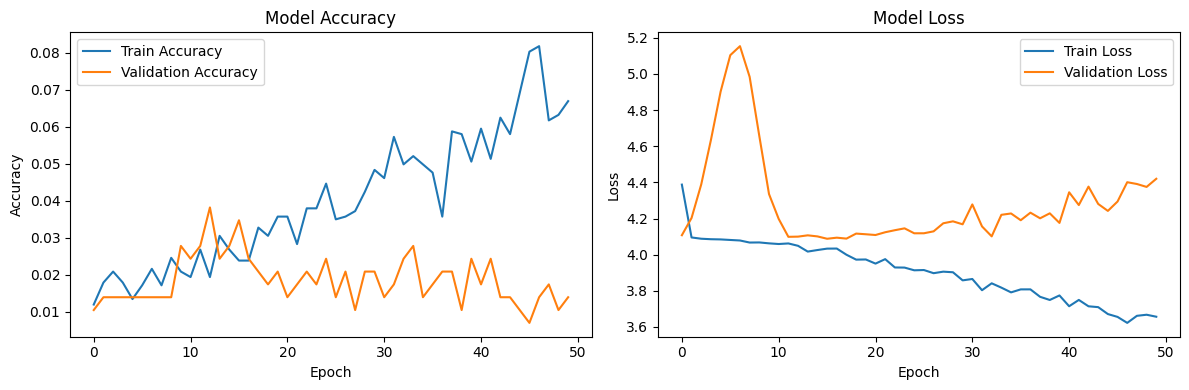

In [ ]:
import matplotlib.pyplot as plt

# --- Plot training & validation accuracy values ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# --- Plot training & validation loss values ---
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

** This part is not very important

# This part focuses on twin/sibling detection

In [ ]:
from sklearn.metrics.pairwise import euclidean_distances # Or cosine_similarity

# --- Get predictions and embeddings for the test set ---
predictions = cnn_model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
decoded_predicted_labels = label_encoder.inverse_transform(predicted_labels)

# --- Get the original embeddings for the test set (from your 'df' before splitting) ---
original_test_embeddings = df[embedding_columns].iloc[np.where(np.isin(y_labels, label_encoder.inverse_transform(y_test)))[0]].values

# --- Get the true labels for the test set (in original string format) ---
true_labels_test = label_encoder.inverse_transform(y_test)

# --- Identify twin/sibling pairs in your dataset (you'll need to define this) ---
twin_sibling_pairs = [('person_A', 'person_B'), ('person_C', 'person_D')] # Example

correct_twin_sibling_predictions = 0
total_twin_sibling_pairs = 0

for i in range(len(true_labels_test)):
    predicted_label = decoded_predicted_labels[i]
    true_label = true_labels_test[i]
    current_embedding = original_test_embeddings[i].reshape(1, -1) # Reshape for distance calculation

    is_twin_sibling = False
    for pair in twin_sibling_pairs:
        if true_label in pair:
            is_twin_sibling = True
            other_twin_sibling = pair[1] if true_label == pair[0] else pair[0]
            break

    if is_twin_sibling:
        total_twin_sibling_pairs += 1
        # --- Get the embedding of the predicted individual from the training data (or a reference set) ---
        try:
            predicted_embedding_index = np.where(y_labels == predicted_label)[0][0] # Find an example
            predicted_embedding = df[embedding_columns].iloc[predicted_embedding_index].values.reshape(1, -1)

            # --- Calculate the distance ---
            distance = euclidean_distances(current_embedding, predicted_embedding)[0][0]
            threshold = 1.0 # You'll need to tune this threshold

            if predicted_label == true_label:
                correct_twin_sibling_predictions += 1
            else:
                # --- Check if the predicted label is the twin/sibling ---
                if predicted_label == other_twin_sibling:
                    # You might have a different criterion here, e.g., if the distance is below a certain value
                    print(f"Misclassified {true_label} (twin/sibling of {other_twin_sibling}) as {predicted_label}, distance: {distance:.4f}")

        except IndexError:
            print(f"Warning: Embedding for predicted label '{predicted_label}' not found in the original data.")

print(f"\nAccuracy on all test samples: {accuracy:.4f}")
if total_twin_sibling_pairs > 0:
    print(f"Accuracy on identified twin/sibling samples: {correct_twin_sibling_predictions / total_twin_sibling_pairs:.4f}")
    print(f"Total identified twin/sibling samples in test set: {total_twin_sibling_pairs}")
else:
    print("No twin/sibling pairs identified in the test set for specific analysis.")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Look this up:

early stoping , evaluation matrics